In [10]:
!pip install librosa

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy
import os
import torch
from warpctc_pytorch import CTCLoss

In [2]:
#Functions for file manipulation
def load_samples(file_path):
    ys, srs = [[]],[[]]
    i = 0
    #loads .wav files
    for filename in os.listdir(file_path):
        if filename.endswith(".wav"):
            y, sr = librosa.load(path+filename, sr=16000)
            ys[i].append(y)
            srs[i].append(sr)
            i = i + 1
            ys.append([])
            srs.append([])  
    ys = ys[0: len(ys) - 1]
    srs = srs[0: len(srs) - 1]
    return (ys, srs)
def load_labels(file_path):
    i = 0
    labels = [[]]
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            file = open(file_path+filename, "r") 
            labels[i].append(file.read())
            labels.append([])
            i = i + 1
            
    labels=labels[0: len(labels) - 1]
    return labels

In [3]:
#Functions for feature extraction
def find_max(ys):
    maximum =0
    for y1 in ys:
        for y2 in y1:
            dim = y2.shape[0]
            if dim > maximum:
                maximum = dim
    return maximum

def pad_signal(ys):
    max_length = find_max(ys)
    
    ys_new = ys
    for i, y1 in enumerate(ys_new):
        for j, y2 in enumerate(y1):
            if len(y2) < max_length:
                z = numpy.zeros((max_length - len(y2)))
                pad_signal = numpy.append(y2, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
                ys_new[i][j] = pad_signal
    return ys_new
def pre_emphasize(ys, pre_emphasis):
    for i, y in enumerate(ys):
        signal=y[0]
        y[0] = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return ys
def fourier_transform(ys, N_FFT=512, window='hamming', hop_size=256):

    Ds = [[]]

    for i, y in enumerate(ys):
        Ds[i].append(librosa.core.stft(y=y[0], n_fft=N_FFT, window=window, hop_length=hop_size))
        Ds.append([])
    return Ds

def mfccs(ys, N_FFT=512, sr=16000, n_mfcc=40, hop_size=256):
    mels = [[]]
    
    for i, y in enumerate(ys):
        mels[i].append(librosa.feature.mfcc(y[0], sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=hop_size))
        mels.append([])
    return mels

# Step 1
* we open the samples and labels

In [4]:
path = "an4_dataset/train/"#path to the dataset

ys, srs = load_samples(path)
labels = load_labels(path)

# Step 2
* loaded data is preprocessed
* we perform stft using librosa
* then we add melspectrogram
* and MFCCs, all are prepared, but we can use each of them, so we get different kinds of features

**Note**: For stft we have a window size, typically 512 or 256 and hop size. On each iteration we start at 
$$
n_1 = N_f x H
$$
and we finish at
$$
n_2 = n_1 + M - 1
$$

https://dsp.stackexchange.com/questions/38491/time-position-in-stft-output

H is a hop size (length) and M is a window size.

In [114]:
ys_new = pad_signal(ys)

ys_emphasized=pre_emphasize(ys_new, 0.97)


In [115]:
N_FFT = 400 #window size
window = 'hamming'
hop_size = 160
N_MFCC = 40

#Ds=fourier_transform(ys=ys_emphasized, N_FFT=N_FFT, window=window, hop_size=hop_size)
Ms=mfccs(ys=ys_emphasized, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)

In [116]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool1d, Dropout2d, Conv1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [165]:
# hyperameters of the model
num_classes = 27
channels = 1
height = 641
width = 40
num_filters_conv1 = 16
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
kernel_size_pool1 = 2
stride_pool1 = 2
num_l1 = 200
padding_conv1 = 0
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)

def comput_conv_1d_dim(dim_size):
    return int((dim_size+2*padding_conv1-dilation*(kernel_size_conv1-1) - 1)/stride_conv1 + 1)
    
def comput_maxPool_dim(dim_size):
    return int((dim_size+2*padding_conv1-dilation*(kernel_size_pool1-1) - 1)/stride_pool1 + 1)

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim + 2 * padding) / stride + 1
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1)
        
        self.maxPool_1 = MaxPool1d(2, stride=2)
        
        #self.conv_out_height = compute_conv_1d_dim(height)
        self.conv_out_width = comput_conv_1d_dim(width)
      #  self.conv_out_height = compute_maxPool_dim(self.conv_out_height)
        self.conv_out_width = comput_maxPool_dim(self.conv_out_width)
        
        # add dropout to network
        #self.dropout = Dropout2d(p=0.5)
        self.l1_in_features = num_filters_conv1*self.conv_out_width
        #self.l1_in_features = channels * height * width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(641, 1, 40)
        x = relu(self.conv_1(x))
        #torch.Size([641, 16, 38])
        x = self.maxPool_1(x)
        #([641, 16, 19])
        x = x.view(1,  641, self.l1_in_features)
        x = relu(self.l_1(x))
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        return torch.nn.functional.log_softmax(self.l_out(x), dim=1)


net = Net()
print(net)

Net(
  (conv_1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (maxPool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_1): Linear(in_features=304, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=27, bias=False)
)


In [156]:
criterion = CTCLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


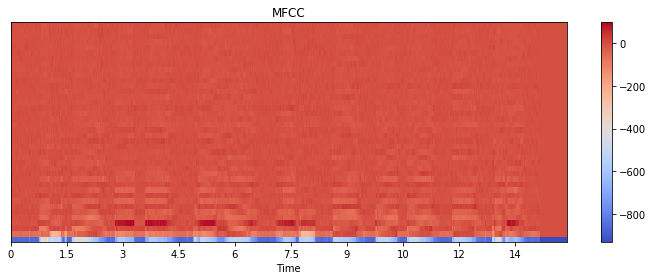

In [157]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(Ms[1][0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


In [158]:
print(len(Ms))
print(len(Ms[0]))
print(len(Ms[0][0].T))

949
1
641


In [159]:
sample = numpy.empty([1,1, 641, 40])
sample[0][0] = Ms[0][0].T
sample_1 = sample[0].reshape((641,1, 40))
#sample=numpy.empty([641, 1, 40])
#for i, row in enumerate(Ms[0][0]):
#    sample[i] = 


In [160]:
print(net.parameters())
#print(batch.shape)
out = net(Variable(torch.from_numpy(sample_1).float()))
print(out.shape)
string = ''.join(labels[0])
string = string.strip()
string = string.replace(" ", "")

output = []
for character in string:
    number = ord(character) - 65
    output.append(number)
print(output)

labels_crit = torch.IntTensor(output)

label_sizes = torch.IntTensor([len(labels_crit)])
probs_sizes = torch.IntTensor([out.shape[1]])

print(out.transpose(0,1).contiguous().shape)

<generator object parameters at 0x7f5383d63e60>
torch.Size([1, 641, 27])
[18, 4, 21, 4, 13, 5, 14, 20, 17, 14, 13, 4, 14, 7, 5, 8, 21, 4, 13, 8, 13, 4, 19, 22, 14]
torch.Size([641, 1, 27])


In [161]:
cost=criterion(out.transpose(0,1).contiguous(), labels_crit, probs_sizes, label_sizes)


In [162]:
cost.backward()

In [163]:
print(cost)

tensor([1570.5289], grad_fn=<_CTCBackward>)


In [164]:
i = 0
num_epochs = 500

j = 0

while i < num_epochs:
    j=0
    
    net.train()
    while j < 50:
        sample = numpy.empty([1,1, 641, 40])
        sample[0][0] = Ms[j][0].T
        sample_1 = sample[0].reshape((641,1, 40))
        
        out = net(Variable(torch.from_numpy(sample_1).float()))
        string = ''.join(labels[j])
        string = string.strip()
        string = string.replace(" ", "")
        #print(string)
        output = []
        for character in string:
            number = ord(character) - 65
            output.append(number)
        #print output

        labels_crit = torch.IntTensor(output)

        label_sizes = torch.IntTensor([len(labels_crit)])
        probs_sizes = torch.IntTensor([out.shape[1]])

        optimizer.zero_grad()
        #print(out.shape)
        #probs.requires_grad_(True)
        #print(probs.grad())
        #labels_crit.requires_grad_(True)
        
        cost=criterion(out.transpose(0,1).contiguous(), labels_crit, probs_sizes, label_sizes)
        cost.backward()
        #print(probs.grad())
        if (j%300==0):
            print("Cost: ")
            print(cost.item())
            print(probs_sizes)
            print(label_sizes)
            print(i)
            print(j)
        j = j + 1
        optimizer.step()
    
    
    i = i + 1

Cost: 
1570.52893066
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
0
0
Cost: 
1344.55859375
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
1
0
Cost: 
1143.32568359
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
2
0
Cost: 
1044.29638672
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
3
0
Cost: 
963.80871582
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
4
0
Cost: 
925.981262207
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
5
0
Cost: 
901.400085449
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
6
0
Cost: 
886.310852051
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
7
0
Cost: 
876.547729492
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
8
0
Cost: 
870.272888184
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
9
0
Cost: 
864.573242188
tensor([641], dtype=torch.int32)
tensor([25], dtype=torch.int32)
10
0
Cost: 
859

KeyboardInterrupt: 